# HSSM Tutorial

This notebook demonstrates how to use the HSSM class to create hierarchical models. The tutorial will be based on simulated data from the [SSM Simulators (SSMS)](https://github.com/AlexanderFengler/ssms) package.

In [4]:
import arviz as az
import numpy as np
import pandas as pd
import pytensor

import hssm
import ssms.basic_simulators

pytensor.config.floatX = "float32"

## Simulating a dataset
-  `dataset` passed to the model should always include 'rt' and 'response'.
-  `dataset` should be a pandas dataframe.

In [5]:
# Simulate some data
v_true, a_true, z_true, t_true, sv_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_ddm = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, sv_true], model="ddm", n_samples=1000
)
obs_ddm = np.column_stack([obs_ddm["rts"][:, 0], obs_ddm["choices"][:, 0]])
dataset = pd.DataFrame(obs_ddm, columns=["rt", "response"])

dataset

,rt,response
0,2.898009,1.0
1,1.602996,1.0
2,1.676999,1.0
3,1.451991,-1.0
4,1.600995,-1.0
...,...,...
995,2.038016,1.0
996,1.582995,-1.0
997,0.948998,-1.0
998,1.383992,1.0


## The simplest case
### DDM using the analytical likelihood function from Navarro & Fuss (2009)

#### Analytical model
Simplest usage of HSSM, only data needs to be provided.

In [6]:
simple_ddm_model = hssm.HSSM(data=dataset)
simple_ddm_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt, response
Observations: 1000

Parameters:

v ~ Uniform(lower: -3.0, upper: 3.0)
sv = 0
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
t ~ Uniform(lower: 0.0, upper: 2.0)

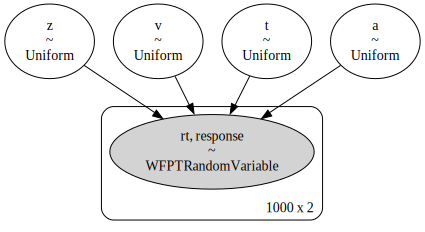

In [7]:
simple_ddm_model.graph()

In [8]:
simple_ddm_model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, t, a, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

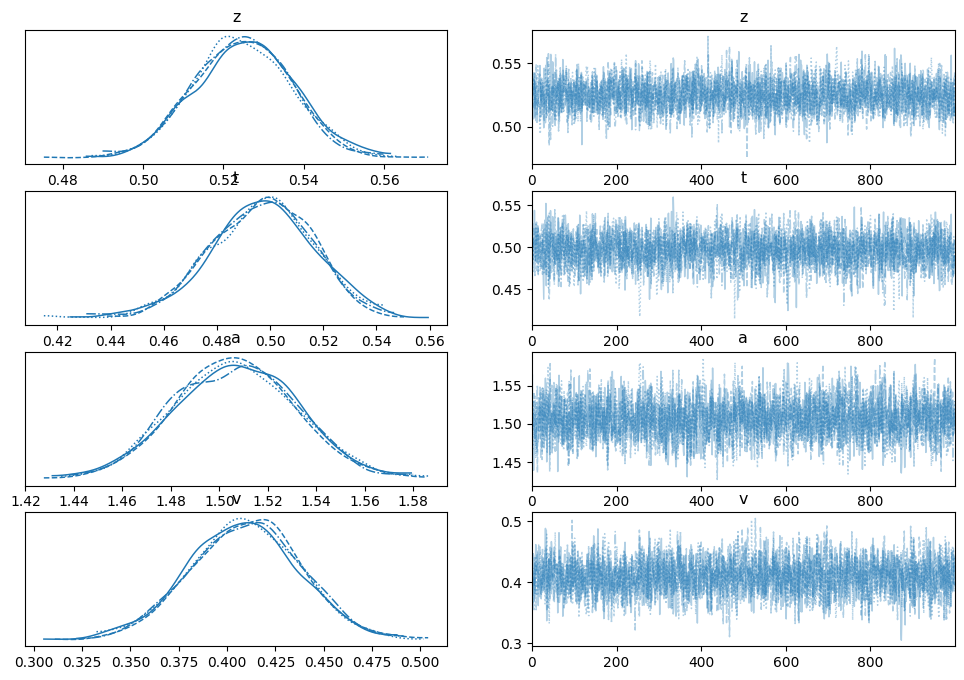

In [9]:
az.plot_trace(simple_ddm_model.trace);

In [10]:
az.summary(simple_ddm_model.trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.525,0.012,0.503,0.548,0.000,0.0,2829.0,2795.0,1.0
t,0.497,0.019,0.462,0.535,0.000,0.0,2633.0,2852.0,1.0
a,1.507,0.025,1.460,1.553,0.000,0.0,2906.0,2983.0,1.0
v,0.409,0.028,0.356,0.462,0.001,0.0,2823.0,2890.0,1.0


## One step up: An angle model using an approximation network

#### Simulating Angle Data

In [52]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs_angle = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
dataset_lan = pd.DataFrame(obs_angle, columns=["rt", "response"])
dataset_lan

,rt,response
0,0.939998,1.0
1,2.384032,1.0
2,0.766000,1.0
3,2.351030,1.0
4,2.344030,-1.0
...,...,...
995,3.793944,-1.0
996,3.550961,1.0
997,2.064017,-1.0
998,0.770000,1.0


This creates a default angle model using pytensor

In [58]:
angle_model = hssm.HSSM(data=dataset_lan, model="angle")
angle_model

Hierarchical Sequential Sampling Model
Model: angle

Response variable: rt, response
Observations: 1000

Parameters:

v ~ Uniform(lower: -3.0, upper: 3.0)
a ~ Uniform(lower: 0.30000001192092896, upper: 3.0)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
t ~ Uniform(lower: 0.0010000000474974513, upper: 2.0)
theta ~ Uniform(lower: -0.10000000149011612, upper: 1.2999999523162842)

In [59]:
pytensor.config.floatX = "float32"

angle_model.sample(cores=1, draws=500, tune=500, mp_ctx="forkserver")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, theta, z, t, v]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 55 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

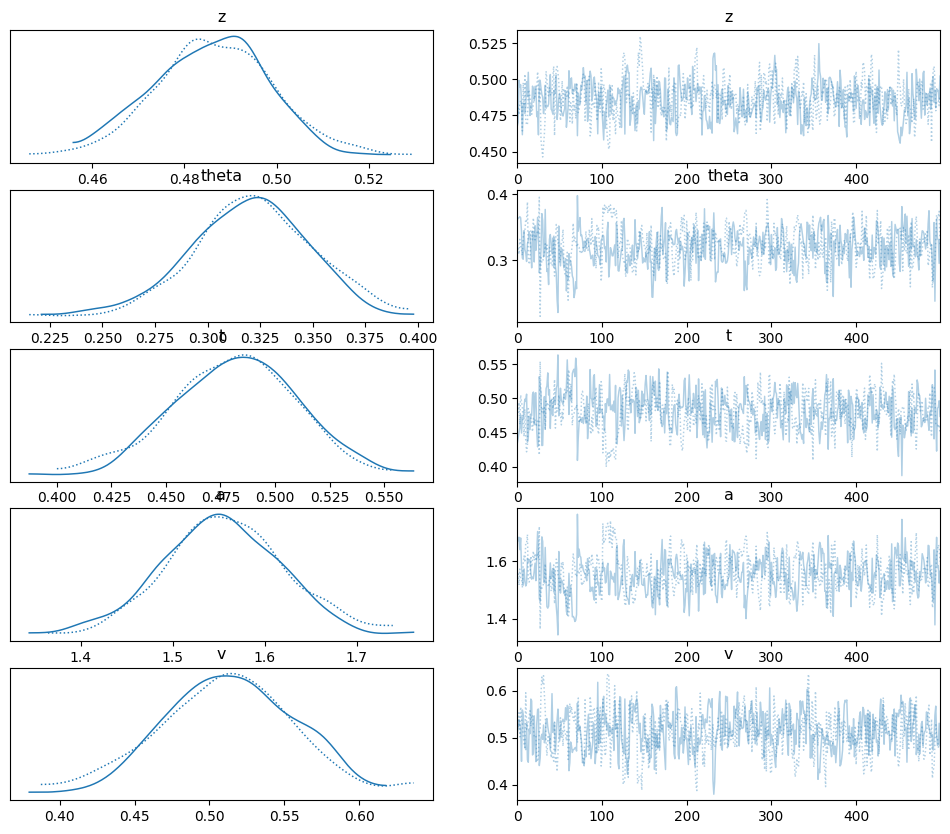

In [15]:
az.plot_trace(angle_model.trace);

#### Sampling the angle model using jax

In [17]:
from jax.config import config

config.update("jax_enable_x64", False)

angle_model.sample(sampler="nuts_numpyro")

/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...


/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pymc/sampling/jax.py:623: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:00.684087
Sampling...


/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)
sample: 100%|█████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 102.78it/s, 15 steps of size 4.47e-01. acc. prob=0.91]
/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for m

Sampling time =  0:01:19.254196
Transforming variables...
Transformation time =  0:00:00.069730


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [18]:
az.summary(angle_model.trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.486,0.013,0.461,0.507,0.001,0.000,372.0,390.0,1.00
theta,0.321,0.028,0.267,0.370,0.002,0.001,321.0,184.0,1.01
t,0.482,0.028,0.432,0.537,0.002,0.001,232.0,237.0,1.01
a,1.556,0.064,1.437,1.675,0.004,0.003,261.0,241.0,1.01
v,0.512,0.043,0.432,0.589,0.002,0.002,379.0,458.0,1.00


### Using include paramater to use regression and update priors.

#### Case 1: Regression type formula. 

In [63]:
# get some fake simulation data
intercept = 0.3
x = np.random.uniform(0.5, 0.2, size=1000)
y = np.random.uniform(0.4, 0.1, size=1000)

v = intercept + 0.8 * x + 0.3 * y

In [64]:
true_values = np.column_stack(
    [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=1000)]
)
true_values.shape

(1000, 5)

In [65]:
obs_ddm_reg_v = ssms.basic_simulators.simulator(true_values, model="ddm", n_samples=1)
obs_ddm_reg_v

dataset_reg_v = pd.DataFrame(
    {
        "rt": obs_ddm_reg_v["rts"].flatten(),
        "response": obs_ddm_reg_v["choices"].flatten(),
        "x": x,
        "y": y,
    }
)

dataset_reg_v

,rt,response,x,y
0,4.250911,1,0.299996,0.231558
1,3.641955,-1,0.301815,0.275295
2,0.855999,1,0.293220,0.318416
3,3.057997,1,0.238952,0.158524
4,1.838006,1,0.298680,0.184872
...,...,...,...,...
995,1.804005,1,0.303993,0.133806
996,2.497037,1,0.410420,0.162951
997,3.752947,1,0.248002,0.150497
998,2.644027,-1,0.330510,0.245272


- v is parent
- x is a feature from the dataset_reg_v
- y is a feature from the dataset_reg_v

In [66]:
model_reg_v = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.0, "upper": 0.5},
                "x": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)
model_reg_v

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt, response
Observations: 1000

Parameters:

v ~ 1 + x + y
	Link: identity
	Intercept ~ Uniform(lower: 0.0, upper: 0.5)
	x ~ Uniform(lower: 0.0, upper: 1.0)
	y ~ Uniform(lower: 0.0, upper: 1.0)
sv = 0
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
t ~ Uniform(lower: 0.0, upper: 2.0)

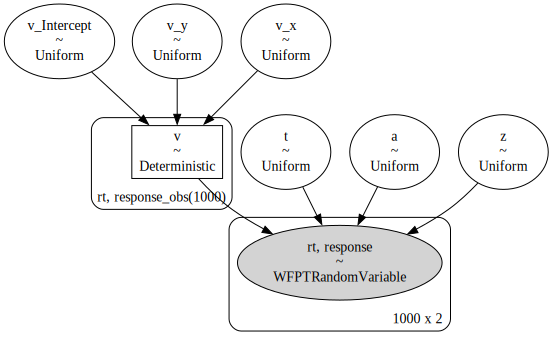

In [61]:
model_reg_v.graph()

In [1]:
trace_reg_v = model_reg_v.sample()

array([[<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 'sv'}>,
        <AxesSubplot: title={'center': 'sv'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 't'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'v_Intercept'}>,
        <AxesSubplot: title={'center': 'v_Intercept'}>],
       [<AxesSubplot: title={'center': 'v_x'}>,
        <AxesSubplot: title={'center': 'v_x'}>],
       [<AxesSubplot: title={'center': 'v_y'}>,
        <AxesSubplot: title={'center': 'v_y'}>]], dtype=object)

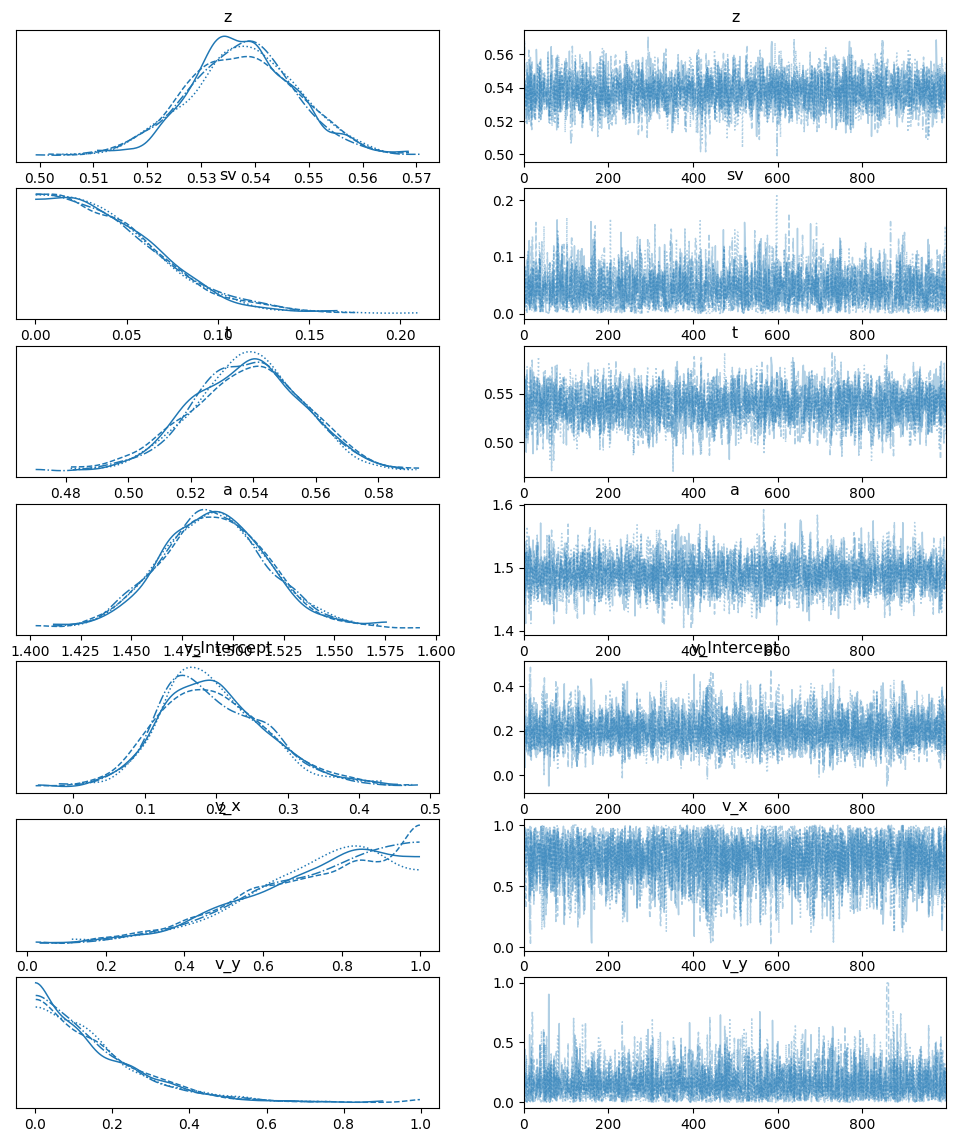

In [25]:
az.plot_trace(model_reg_v.trace)

In [52]:
# Looks like parameter recovery was successful
az.summary(model_reg_v.trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.547,0.014,0.528,0.567,0.005,0.004,8.0,4.0,1.45
t,0.561,0.067,0.500,0.674,0.033,0.025,7.0,2722.0,1.53
a,1.509,0.062,1.439,1.608,0.029,0.022,7.0,2429.0,1.53
v_Intercept,0.118,0.077,0.001,0.278,0.018,0.013,20.0,2492.0,1.14
v_x,0.682,0.216,0.404,0.984,0.081,0.060,9.0,4.0,1.34
v_y,0.333,0.181,0.000,0.649,0.003,0.002,3912.0,1914.0,1.53


#### Case 2: adding initval to priors along with lower and upper.

- v is a parent
- x is a feature from the dataset_reg_v

Adding initval is optional.

In [46]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 1.0,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "v ~ 1 + x",
        }
    ],
)

In [47]:
hssm_include_val.params

[v ~ 1 + x
 	Link: identity
 	Intercept ~ Uniform(lower: -3.0, upper: 3.0, initval: 1.0)
 	x ~ Uniform(lower: -0.5, upper: 0.5, initval: 0.0),
 sv = 0,
 a ~ Uniform(lower: 0.30000001192092896, upper: 2.5),
 z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421),
 t ~ Uniform(lower: 0.0, upper: 2.0)]

In [48]:
samples_two = hssm_include_val.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, t, a, v_Intercept, v_x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [49]:
az.summary(samples_two)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.518,0.013,0.494,0.542,0.000,0.000,3193.0,2995.0,1.0
t,0.495,0.020,0.460,0.534,0.000,0.000,3066.0,2837.0,1.0
a,1.504,0.027,1.455,1.557,0.000,0.000,3716.0,3109.0,1.0
v_Intercept,0.495,0.043,0.415,0.576,0.001,0.001,3672.0,3188.0,1.0
v_x,0.410,0.085,0.260,0.500,0.001,0.001,2749.0,1824.0,1.0


#### Case 3: not specifying parent v in the include parameter. 

The parent is v by default, specifying it is not mandatory. 

In [28]:
hssm_include_val = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "a",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": 0.0,
                    "upper": 1.0,
                    "initval": 0.5,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "a ~ 1 + x",
        }
    ],
)

In [29]:
hssm_include_val

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt, response
Observations: 1000

Parameters:

a ~ 1 + x
	Link: identity
	Intercept ~ Uniform(lower: 0.0, upper: 1.0, initval: 0.5)
	x ~ Uniform(lower: -0.5, upper: 0.5, initval: 0.0)
v ~ Uniform(lower: -3.0, upper: 3.0)
sv = 0
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
t ~ Uniform(lower: 0.0, upper: 2.0)

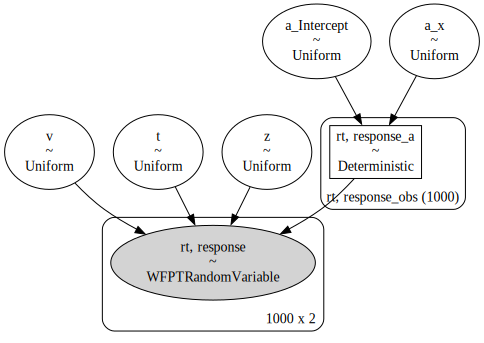

In [30]:
hssm_include_val.graph()

In [31]:
samples_three = hssm_include_val.sample(draws=500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, t, v, a_Intercept, a_x]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 390 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [50]:
az.summary(samples_three)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.495,0.010,0.477,0.514,0.001,0.000,369.0,251.0,1.01
t,0.659,0.001,0.657,0.660,0.000,0.000,445.0,281.0,1.03
v_Intercept,0.076,0.124,-0.177,0.287,0.019,0.014,42.0,73.0,1.07
v_x,0.450,0.259,0.040,0.977,0.047,0.035,28.0,30.0,1.11
v_y,0.085,0.322,-0.480,0.683,0.035,0.030,85.0,99.0,1.04


#### Case 4, including multiple dictionaries in the include parameter. Creating hierarchical model. 

In [37]:
hssm_include_list = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "v ~ 1 + x + y",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "a ~ 1 + x + y",
        },
    ],
)

In [38]:
hssm_include_list.model

       Formula: c(rt, response) ~ 1 + x + y
                a ~ 1 + x + y
        Family: analytical
          Link: v = identity
                a = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Uniform(lower: -2.0, upper: 3.0)
            x ~ Uniform(lower: -0.5, upper: 0.5)
            y ~ Uniform(lower: -0.5, upper: 0.5)
        
        Auxiliary parameters
            c(rt, response)_z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
            c(rt, response)_sv ~ 0
            c(rt, response)_t ~ Uniform(lower: 0.0, upper: 2.0)
    target = a
        Common-level effects
            a_Intercept ~ Uniform(lower: -2.0, upper: 3.0)
            a_x ~ Uniform(lower: -0.5, upper: 0.5)
            a_y ~ Uniform(lower: -0.5, upper: 0.5)

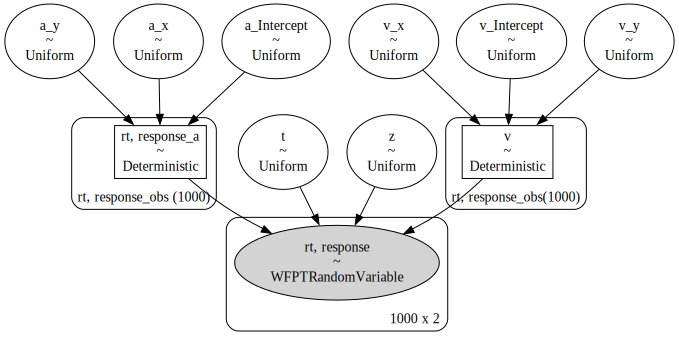

In [39]:
hssm_include_list.graph()

In [40]:
samples_two = hssm_include_list.sample(draws=100, tune=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, t, v_Intercept, v_x, v_y, a_Intercept, a_x, a_y]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 17 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 300 divergences after tuning. Increase `target_accept` or reparameterize.


#### Case 5. including multiple dictionaries in the include parameter. Specifying prior as a float number. 

In [43]:
hssm_include_list = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -2.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
        },
        {"name": "a", "prior": 0.5},
    ],
)

In [44]:
samples_three = hssm_include_list.sample(draws=100, tune=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, t, v_Intercept, v_x, v_y]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
